In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('For Lab2.csv')
df

AQI Category  AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
0                 0         51             1               36              0   
1                 1         41             1                5              1   
2                 1         41             1                5              1   
3                 0         66             1               39              2   
4                 1         34             1               34              0   
...             ...        ...           ...              ...            ...   
16388             0         54             1               34              5   
16389             0         71             1               39              1   
16390             0         71             1               39              1   
16391             1         50             1               20              5   
16392             0         71             1               44              2   

       PM2.5 AQI Value  
0                   51  
1                   41  
2                   41  
3                   66  
4                   20  
...                ...  
16388               54  
16389               71  
16390               71  
16391               50  
16392               71  

[16393 rows x 6 columns]

In [3]:
from sklearn.preprocessing import MinMaxScaler


X = df.drop(['AQI Category'], axis=1)
y = df['AQI Category'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
pd.DataFrame(X_scaled, columns=X.columns)

AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
0       0.089249      0.007519         0.162162       0.000000   
1       0.068966      0.007519         0.022523       0.010989   
2       0.068966      0.007519         0.022523       0.010989   
3       0.119675      0.007519         0.175676       0.021978   
4       0.054767      0.007519         0.153153       0.000000   
...          ...           ...              ...            ...   
16388   0.095335      0.007519         0.153153       0.054945   
16389   0.129817      0.007519         0.175676       0.010989   
16390   0.129817      0.007519         0.175676       0.010989   
16391   0.087221      0.007519         0.090090       0.054945   
16392   0.129817      0.007519         0.198198       0.021978   

       PM2.5 AQI Value  
0                0.102  
1                0.082  
2                0.082  
3                0.132  
4                0.040  
...                ...  
16388            0.108  
16389            0.142  
16390            0.142  
16391            0.100  
16392            0.142  

[16393 rows x 5 columns]

## 1. Dimension Reduction

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [6]:
X_pca.shape

(16393, 5)

In [7]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

print('Explained variance', exp_var_pca)
print('Cumulative explained variance', cum_sum_eigenvalues)

Explained variance [0.56905593 0.32794755 0.09183598 0.00755753 0.00360301]
Cumulative explained variance [0.56905593 0.89700347 0.98883946 0.99639699 1.        ]


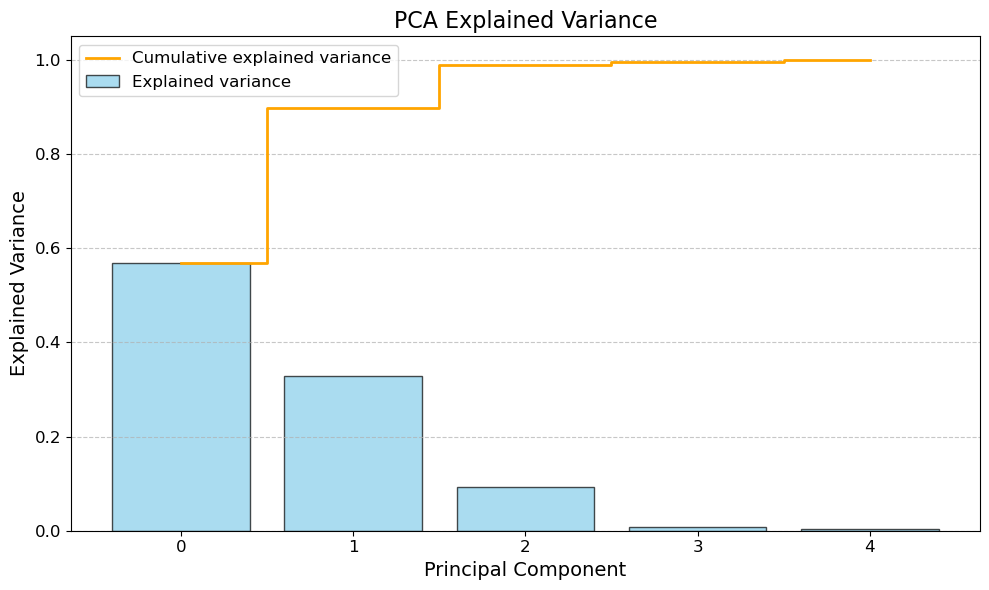

In [8]:
plt.figure(figsize=(10, 6))

bars = plt.bar(range(len(exp_var_pca)), exp_var_pca, align='center', color='skyblue', edgecolor='black', alpha=0.7, label='Explained variance')

plt.step(range(len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='orange', linewidth=2, label='Cumulative explained variance')

plt.ylabel('Explained Variance', fontsize=14)
plt.xlabel('Principal Component', fontsize=14)
plt.title('PCA Explained Variance', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
pca_result_df = pd.DataFrame({'pca_1': X_pca[:,0], 'pca_2': X_pca[:,1], 'label': y})

In [10]:
import plotly.express as px

fig = px.scatter(
    pca_result_df, 
    x='pca_1', 
    y='pca_2', 
    color='label', 
    title='PCA Visualization',
    labels={'pca_1': 'PCA Component 1', 'pca_2': 'PCA Component 2'},
    template='plotly_dark',  
    color_continuous_scale=px.colors.sequential.Sunset, 
    opacity=0.7             
)


fig.update_traces(marker=dict(size=10, line=dict(width=2, color='DarkSlateGrey')))
fig.update_layout(title_font_size=20)

# Показ графіку
fig.show()

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
tsne_result = tsne.fit_transform(X_scaled)

In [12]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})

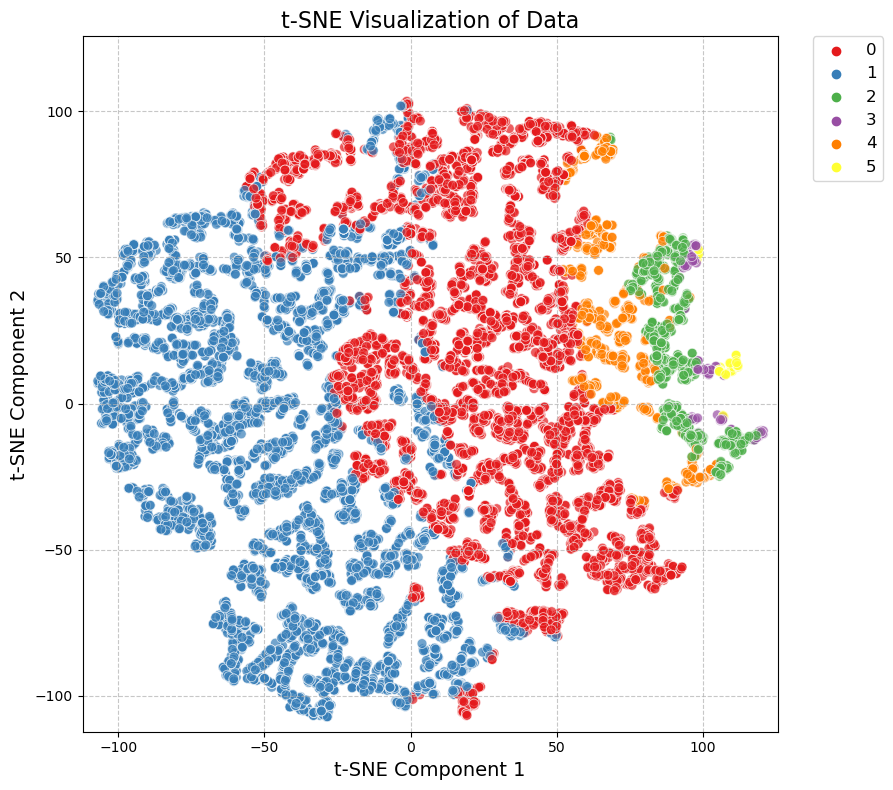

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=50, palette='Set1', alpha=0.7)

lim = (tsne_result_df[['tsne_1', 'tsne_2']].min().min() - 5, tsne_result_df[['tsne_1', 'tsne_2']].max().max() + 5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')

ax.set_title('t-SNE Visualization of Data', fontsize=16)
ax.set_xlabel('t-SNE Component 1', fontsize=14)
ax.set_ylabel('t-SNE Component 2', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 2. Cluster Analysis for picture

In [14]:
import cv2
from sklearn.cluster import KMeans


In [15]:
def quantize_image(image, n_colors):
    data = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(data)
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    quantized_image = new_colors.reshape(image.shape).astype(np.uint8)
    return quantized_image


In [16]:
def display_images(original, quantized_images, n_colors_list):
    plt.figure(figsize=(8, 15)) 
    
    plt.subplot(len(quantized_images) + 1, 1, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")
    
    for i, (img, n_colors) in enumerate(zip(quantized_images, n_colors_list)):
        plt.subplot(len(quantized_images) + 1, 1, i + 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{n_colors} colors")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [17]:
img = cv2.imread('colosseum-in-full-view-in-rome.jpg')

In [18]:
if img is None:
    print("Зображення не знайдено або шлях до файлу неправильний!")
else:
    n_colors_list = [64, 32, 16, 8]
    quantized_images = [quantize_image(img, n_colors) for n_colors in n_colors_list]

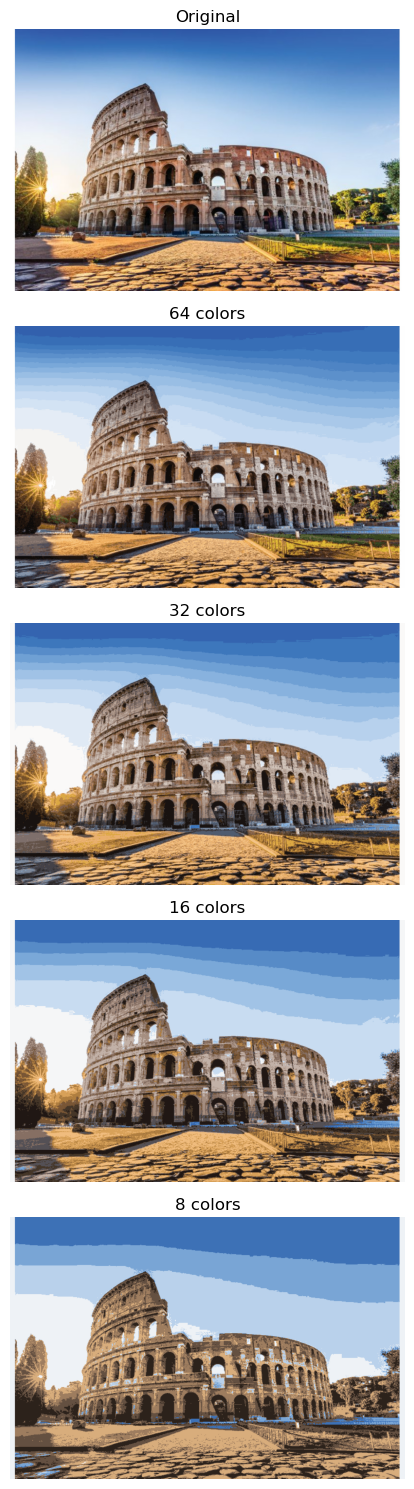

In [19]:
display_images(img, quantized_images, n_colors_list)

## 3. Text data Classification

In [21]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import re
import string

In [22]:
train_df = pd.read_csv('Sciences train.csv')
test_df = pd.read_csv('Sciences test.csv')

In [23]:
train_df

Id                                            Comment      Topic
0      0x840  A few things. You might have negative- frequen...    Biology
1      0xbf0  Is it so hard to believe that there exist part...    Physics
2     0x1dfc                                     There are bees    Biology
3      0xc7e  I'm a medication technician. And that's alot o...    Biology
4      0xbba                     Cesium is such a pretty metal.  Chemistry
...      ...                                                ...        ...
8690  0x1e02  I make similar observations over the last week...    Biology
8691   0xc8d                                    You would know.    Biology
8692   0x723            Also use the correct number of sig figs  Chemistry
8693   0x667  What about the ethical delimmas,  groundbreaki...    Biology
8694  0x1476                          I would like to know too.    Biology

[8695 rows x 3 columns]

In [24]:
test_df

Id                                            Comment      Topic
0     0x1aa9  Personally I have no idea what my IQ is. I’ve ...    Biology
1      0x25e  I'm skeptical. A heavier lid would be needed t...    Physics
2     0x1248  I think I have 100 cm of books on the subject....    Biology
3      0x2b9  Is chemistry hard in uni. Ive read somewhere t...  Chemistry
4     0x24af  In addition to the other comment, you can crit...    Physics
...      ...                                                ...        ...
1581  0x22bf  I’m not really denying your intent. I’m a) dou...  Chemistry
1582  0x1f4a  i really empathize with your compassion for bu...    Biology
1583  0x27b7  If you want to keep it for more than 2 weeks, ...  Chemistry
1584  0x2066  Same here. I’m in nursing school so I only hav...    Biology
1585   0x6d6  The video basically says read a pop-sci book a...    Physics

[1586 rows x 3 columns]

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       8695 non-null   object
 1   Comment  8695 non-null   object
 2   Topic    8695 non-null   object
dtypes: object(3)
memory usage: 203.9+ KB


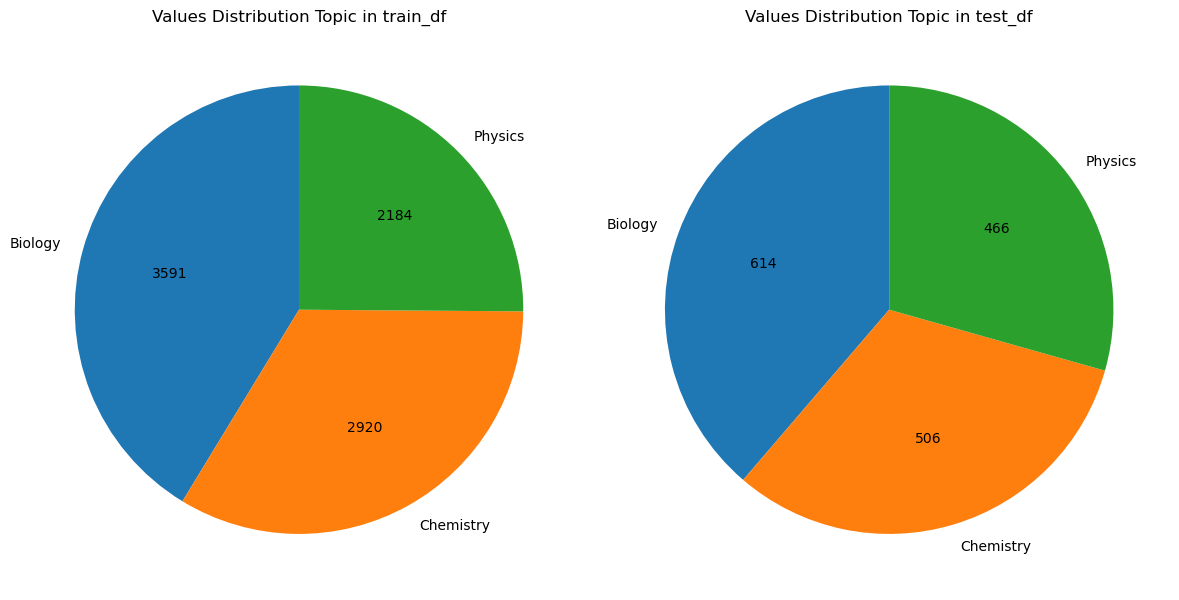

In [26]:
def plot_topic_distribution(df1, df2, column_name):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    counts1 = df1[column_name].value_counts()
    counts1.plot.pie(ax=axes[0], autopct=lambda p: '{:.0f}'.format(p * counts1.sum() / 100), startangle=90)
    axes[0].set_ylabel('')
    axes[0].set_title(f'Values Distribution {column_name} in train_df')

    counts2 = df2[column_name].value_counts()
    counts2.plot.pie(ax=axes[1], autopct=lambda p: '{:.0f}'.format(p * counts2.sum() / 100), startangle=90)
    axes[1].set_ylabel('')
    axes[1].set_title(f'Values Distribution {column_name} in test_df')
    
    plt.tight_layout() 
    plt.show()
    
plot_topic_distribution(train_df, test_df, 'Topic')

In [27]:
def count_missings(df):
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.concat([missing_values, missing_percentage], axis=1)
    missing_df.columns = ['Missing Count', 'Missing %']
    missing_df_sorted = missing_df[missing_df['Missing %'] > 0.01].sort_values(by='Missing %', ascending=False)
    
    return missing_df_sorted

count_missings(train_df)

Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

In [28]:
train_df.dropna(inplace=True)

In [29]:
train_df = train_df[['Comment', 'Topic']]
test_df = test_df[['Comment', 'Topic']]

In [30]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    text = re.sub('@\S+', ' ', text)
    text = re.sub('https*\S+', ' ', text)
    text = re.sub('#\S+', ' ', text)
    text = re.sub('\d', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}', ' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    text = ' '.join([word for word in words if word.isalpha()])

    return text

train_df.Comment = train_df.Comment.apply(clean_text)
test_df.Comment = test_df.Comment.apply(clean_text)

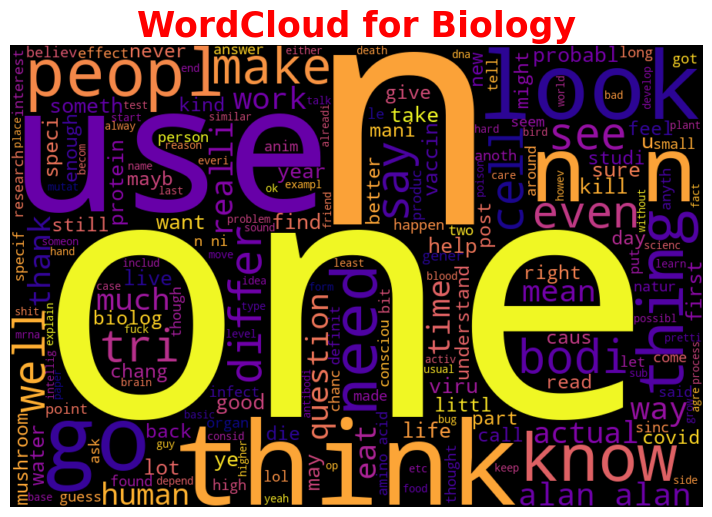

In [31]:
from wordcloud import WordCloud

def generate_wordcloud(data, category_col, text_col, category_value):
    
    category_data = data[data[category_col] == category_value]
    
    combined_text = ' '.join(category_data[text_col].str.lower())
    
    wordcloud = WordCloud(width=900, height=600, background_color='black',      
                           colormap='plasma', max_words=200, contour_color='white', contour_width=1).generate(combined_text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud for {category_value}', fontsize=25, weight='bold', color = 'red')
    plt.axis('off')
    plt.show()


generate_wordcloud(train_df, 'Topic', 'Comment', 'Biology')
generate_wordcloud(train_df, 'Topic', 'Comment', 'Physics')
generate_wordcloud(train_df, 'Topic', 'Comment', 'Chemistry')

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(train_df['Comment'])
X_test = vectorizer.transform(test_df['Comment'])

y_train = train_df.Topic
y_test =  test_df.Topic

accuracy score 0.8329129886506935
              precision    recall  f1-score   support

     Biology       0.84      0.84      0.84       614
   Chemistry       0.80      0.84      0.82       506
     Physics       0.86      0.82      0.84       466

    accuracy                           0.83      1586
   macro avg       0.83      0.83      0.83      1586
weighted avg       0.83      0.83      0.83      1586



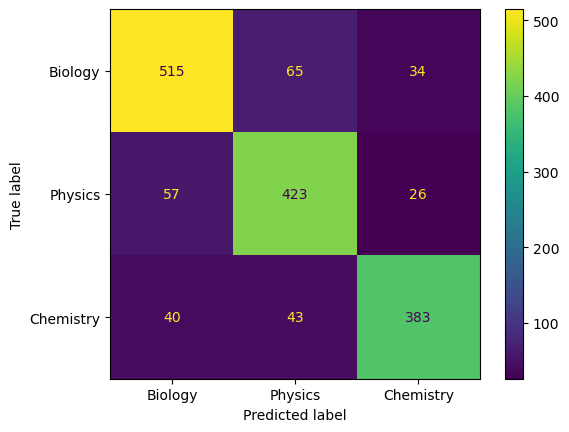

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classifier = LogisticRegression(max_iter=100).fit(X_train,y_train)

y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)
print('accuracy score', accuracy_score(y_test, y_pred))
print(report)
cm = confusion_matrix(y_test, y_pred)
cm_display=ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Biology','Physics','Chemistry'])
cm_display.plot()

accuracy score 0.8461538461538461
              precision    recall  f1-score   support

     Biology       0.89      0.84      0.86       614
   Chemistry       0.79      0.85      0.82       506
     Physics       0.86      0.85      0.86       466

    accuracy                           0.85      1586
   macro avg       0.85      0.85      0.85      1586
weighted avg       0.85      0.85      0.85      1586



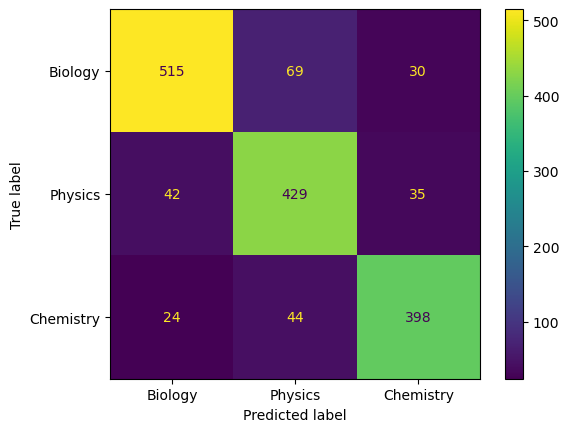

In [34]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB(alpha=0.1).fit(X_train, y_train)

y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)
print('accuracy score', accuracy_score(y_test, y_pred))
print(report)
cm = confusion_matrix(y_test, y_pred)
cm_display=ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Biology','Physics','Chemistry'])
cm_display.plot()